In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Obtener los errores correctos en los parámetros de ajuste puede ser sutil en la mayoría de los casos.

Pensemos en el ajuste de una función $y=f(x)$ para la que tenemos un conjunto de puntos de datos $(x_i, y_i, yerr_i)$, donde $i$ es un índice que recorre cada uno de los puntos de datos.

En la mayoría de las mediciones físicas, el error $yerr_i$ es una incertidumbre sistemática del dispositivo o procedimiento de medición, por lo que puede considerarse como una constante que no depende de $i$.

## ¿Qué función de ajuste utilizar y cómo obtener los errores de los parámetros?

El método `optimize.leastsq` devolverá la matriz de covarianza fraccional. Si se multiplican todos los elementos de esta matriz por la varianza residual (es decir, la chi cuadrada reducida) y se saca la raíz cuadrada de los elementos diagonales, se obtendrá una estimación de la desviación estándar de los parámetros de ajuste. He incluido el código para hacer esto en una de las funciones de abajo.

# Veamos algunos ejemplos

En primer lugar, un poco de código. Vamos a definir una función de línea cuadriculada y a generar algunos datos con errores aleatorios. Vamos a generar un conjunto de datos con un pequeño error aleatorio.

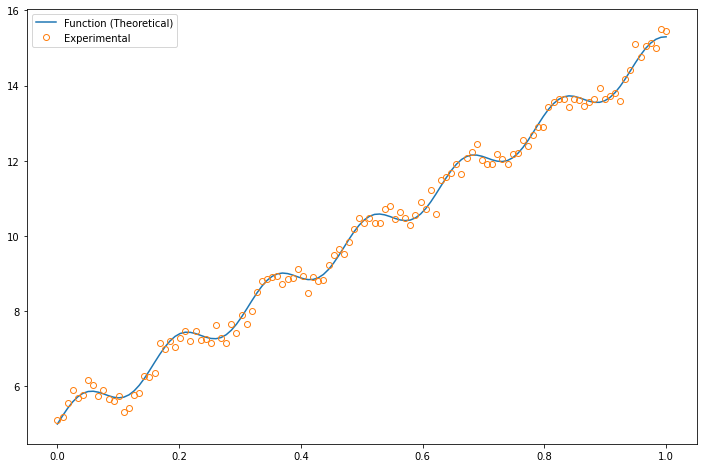

In [2]:
def f( x, p0, p1, p2):
    return p0*x + 0.4*np.sin(p1*x) + p2

def ff(x, p):
    return f(x, *p)

# These are the true parameters
p0 = 10.0
p1 = 40
p2 = 5.0

# These are initial guesses for fits:
pstart = [
    p0 + 3.*random.random(),
    p1 + 5.*random.random(), 
    p2 + 2.*random.random()
]

xvals = np.linspace(0., 1, 120)
yvals = f(xvals, p0, p1, p2)

# Generate data with a bit of randomness
# (the noise-less function that underlies the data is shown as a blue line)

xdata = np.array(xvals)
np.random.seed(42)
err_stdev = 0.2
yvals_err =  np.random.normal(0., err_stdev, len(xdata))
ydata = f(xdata, p0, p1, p2) + yvals_err

plt.figure(figsize=(12,8))
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.legend()
plt.show()

# `optimize.leastsq`

In [3]:
#from scipy.optimize import curve_fit, optimize, least_squares, optimize
#from scipy.optimize import least_squares
from scipy.optimize import curve_fit, least_squares, leastsq

In [4]:
def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = leastsq(errfunc, p0, args=(datax, datay), full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

pfit1, perr1 = fit_leastsq(pstart, xdata, ydata, ff)

print("\n# Fit parameters and parameter errors from lestsq method :")
print("pfit = ", pfit1)
print("perr = ", perr1)


# Fit parameters and parameter errors from lestsq method :
pfit =  [10.04951642 39.98832633  4.95947613]
perr =  [0.0584024  0.10597135 0.03376631]


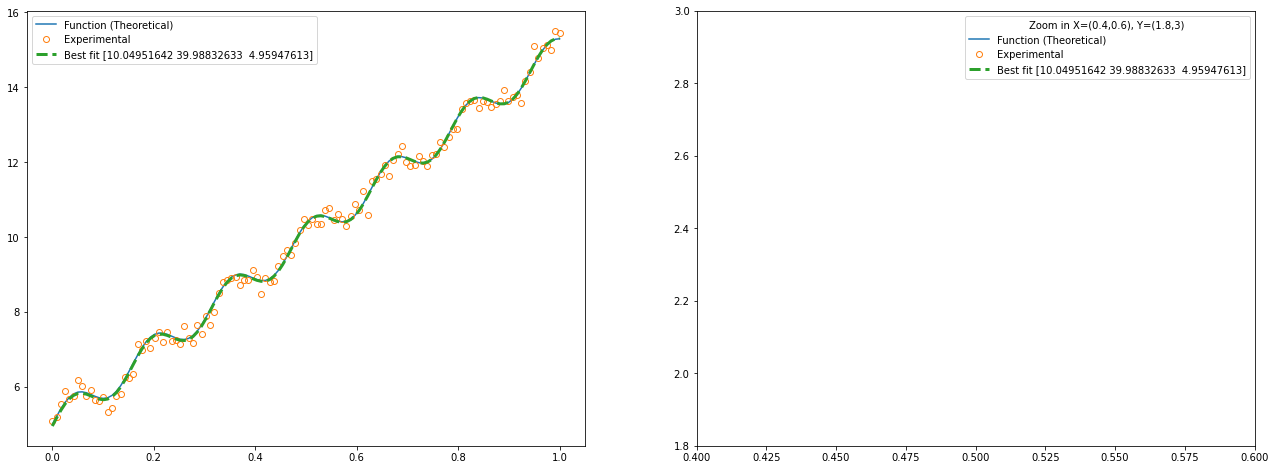

In [5]:
plt.figure(figsize=(22,8))
plt.subplot(121)
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.plot(xdata, f(xdata, *pfit1), linestyle='--', lw=3, mfc='None', label="Best fit {}".format(pfit1))
plt.legend()
plt.subplot(122)
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.plot(xdata, f(xdata, *pfit1), linestyle='--', lw=3, mfc='None', label="Best fit {}".format(pfit1))
plt.axis([0.4,0.6,1.8,3])
plt.legend(title="Zoom in X=(0.4,0.6), Y=(1.8,3)")
plt.show()

# `optimize.curve_fit`

Este fue el que vimos en el otro Notebook

# `bootstrap`

In [6]:
def fit_bootstrap(p0, datax, datay, function, yerr_systematic=0.0):

    errfunc = lambda p, x, y: function(x,p) - y

    # Fit first time
    pfit, perr = leastsq(errfunc, p0, args=(datax, datay), full_output=0)

    # Get the stdev of the residuals
    residuals = errfunc(pfit, datax, datay)
    sigma_res = np.std(residuals)

    sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

    # 100 random data sets are generated and fitted
    ps = []
    for i in range(100):

        randomDelta = np.random.normal(0., sigma_err_total, len(datay))
        randomdataY = datay + randomDelta

        randomfit, randomcov = leastsq(errfunc, p0, args=(datax, randomdataY), full_output=0)

        ps.append(randomfit) 

    ps = np.array(ps)
    mean_pfit = np.mean(ps,0)

    # You can choose the confidence interval that you want for your
    # parameter estimates: 
    Nsigma = 1. # 1sigma gets approximately the same as methods above
                # 1sigma corresponds to 68.3% confidence interval
                # 2sigma corresponds to 95.44% confidence interval
    err_pfit = Nsigma * np.std(ps,0) 

    pfit_bootstrap = mean_pfit
    perr_bootstrap = err_pfit
    return pfit_bootstrap, perr_bootstrap, datax, randomdataY

pfit2, perr2, datax, randomdataY = fit_bootstrap(pstart, xdata, ydata, ff)

print("\n# Fit parameters and parameter errors from bootstrap method :")
print("pfit = ", pfit2)
print("perr = ", perr2)


# Fit parameters and parameter errors from bootstrap method :
pfit =  [10.04889395 39.95305865  4.95931801]
perr =  [0.05777303 0.11094086 0.03163813]


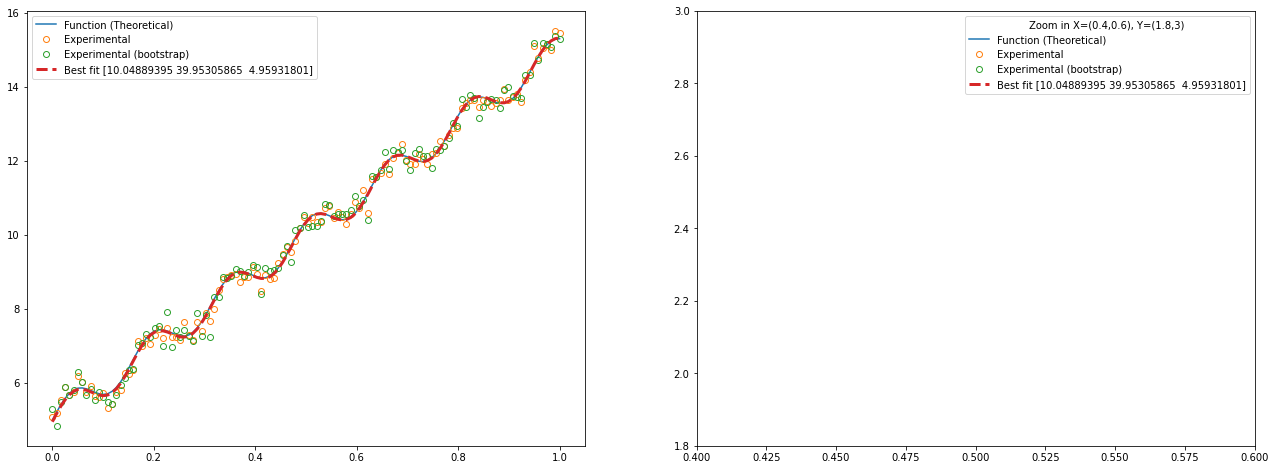

In [7]:
plt.figure(figsize=(22,8))
plt.subplot(121)
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.plot(datax, randomdataY, 'o', mfc='None', label="Experimental (bootstrap)")
plt.plot(xdata, f(xdata, *pfit2), linestyle='--', lw=3, mfc='None', label="Best fit {}".format(pfit2))
plt.legend()
plt.subplot(122)
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.plot(datax, randomdataY, 'o', mfc='None', label="Experimental (bootstrap)")
plt.plot(xdata, f(xdata, *pfit2), linestyle='--', lw=3, mfc='None', label="Best fit {}".format(pfit2))
plt.axis([0.4,0.6,1.8,3])
plt.legend(title="Zoom in X=(0.4,0.6), Y=(1.8,3)")
plt.show()

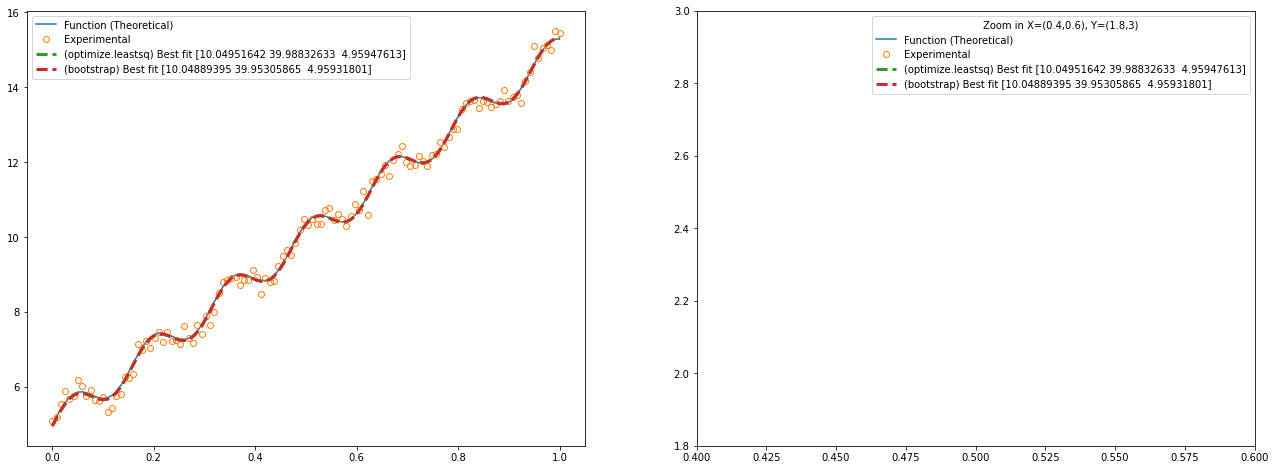

In [8]:
plt.figure(figsize=(22,8))
plt.subplot(121)
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.plot(xdata, f(xdata, *pfit1), linestyle='--', lw=3, mfc='None', label="(optimize.leastsq) Best fit {}".format(pfit1))
plt.plot(xdata, f(xdata, *pfit2), linestyle='--', lw=3, mfc='None', label="(bootstrap) Best fit {}".format(pfit2))
plt.legend()
plt.subplot(122)
plt.plot(xvals, yvals, label="Function (Theoretical)")
plt.plot(xdata, ydata, 'o', mfc='None', label="Experimental")
plt.plot(xdata, f(xdata, *pfit1), linestyle='--', lw=3, mfc='None', label="(optimize.leastsq) Best fit {}".format(pfit1))
plt.plot(xdata, f(xdata, *pfit2), linestyle='--', lw=3, mfc='None', label="(bootstrap) Best fit {}".format(pfit2))
plt.axis([0.4,0.6,1.8,3])
plt.legend(title="Zoom in X=(0.4,0.6), Y=(1.8,3)")
plt.show()

In [9]:
#Errores
E1=np.sqrt(np.mean((ydata-f(xdata, *pfit1))**2))
E2=np.sqrt(np.mean((ydata-f(xdata, *pfit2))**2))

print("Error using optimize.leastsq =", E1)
print("Error using bootstrap =", E2)

# ¿Quien en mayor?
print("---------------------------------------------------------------")
print("which method gives more errors?")
print("---------------------------------------------------------------")
if E1/E2>=1:
    print("optimize.leastsq give more error than bootstrap, (E1/E2)=", np.round(E1/E2,5))
if E1/E2<1:
    print("bootstrap gives more error than optimize.leastsq, (E1/E2)=", np.round(E1/E2,5))
print("---------------------------------------------------------------")


Error using optimize.leastsq = 0.1836988662885654
Error using bootstrap = 0.1836959679440949
---------------------------------------------------------------
which method gives more errors?
---------------------------------------------------------------
optimize.leastsq give more error than bootstrap, (E1/E2)= 1.00002
---------------------------------------------------------------


# Resumen

`optimize.leastsq` y `optimize.curvefit` nos proporcionan una forma de estimar los errores en los parámetros ajustados, pero no podemos utilizar estos métodos sin cuestionarlos un poco. El `bootstrap` es un método estadístico que utiliza la fuerza bruta, y en mi opinión, tiene una tendencia a trabajar mejor en situaciones que pueden ser más difíciles de interpretar.

Recomiendo encarecidamente mirar un problema en particular, y probar `curvefit` y `bootstrap`. Si son similares, entonces `curvefit` es mucho más barato de calcular, así que probablemente valga la pena usarlo. Si difieren significativamente, entonces mi FE estaría puesta en el `bootstrap`. 